#### playground

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import scipy.optimize as opt

#import tensorly as tl#use tensorly to do tensor decompostion
#from tensorly.decomposition import parafac
#tl.set_backend('numpy') # or any other backend

import datetime
import time
#import winsound#sound alarm when code finishes, only in windows

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)

torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
# Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
# use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig7_training_inputs.npy')
training_set = np.load('../data/fig7_training_set.npy')
test_inputs = np.load('../data/fig7_test_inputs.npy')
test_set = np.load('../data/fig7_test_set.npy')
input_bg_mean_f   = np.mean(training_inputs[:14000],axis=(0,2,3,4),keepdims=True)/255
print (input_bg_mean_f)

[[[[[0.14652802]]]


  [[[0.14858697]]]]]


### inspect loaded data

#### 86 neurons, 108+15 NM 

In [5]:
print(training_inputs.shape)
print(training_set.shape)
print(test_inputs.shape)
print(test_set.shape)

(16200, 2, 50, 36, 32)
(16200, 86)
(750, 2, 50, 36, 32)
(750, 86)


#### split training data into:
1. training
2. validation

In [6]:
# split original training data into two parts, training loader: 2200, validation loader: 200
# make the dataset suitable for pytorch
train_loader=[]
for ii in range(0,13000,200):
    temp0 = training_inputs[ii:ii+200]/255 - input_bg_mean_f # center the stimulus
    temp1 = training_set[ii:ii+200] # 100*200(neurons)
    temp = (temp0,temp1)
    train_loader.append(temp)

temp0 = training_inputs[13000:]/255 - input_bg_mean_f # center the stimulus
temp1 = training_set[13000:] # 200*200(neurons)
val_loader = (temp0,temp1)

temp0 = np.copy(test_inputs)/255 - input_bg_mean_f #center the stimulus
temp1 = np.copy(test_set) # 50*200(neurons)
test_loader = (temp0,temp1)

print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)

length of train_loader:
65
shape of train_loader[0][0]:
(200, 2, 50, 36, 32)
shape of train_loader[0][1]:
(200, 86)
shape of val_loader[0]:
(3200, 2, 50, 36, 32)
shape of val_loader[1]:
(3200, 86)
shape of test_loader[0]:
(750, 2, 50, 36, 32)
shape of test_loader[1]:
(750, 86)


In [7]:
del training_inputs,training_set,test_inputs,test_set

#### visualization of the stimulus input
e.g.show the first 10 frames (uv_chan) as examples

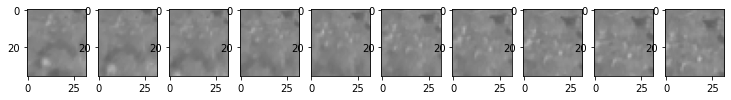

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    
    axes[ii].imshow(train_loader[30][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False) 
    # axes[ii,jj].axis('tight')

#### visualization of example neural responses
e.g. the last 5 cells

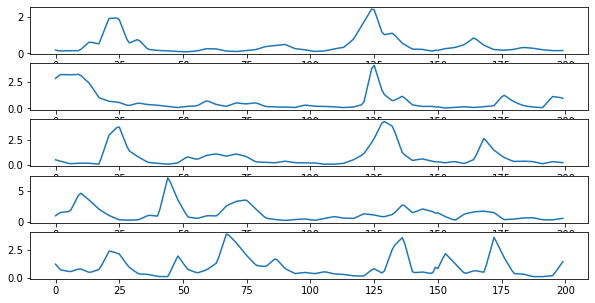

In [9]:
# visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

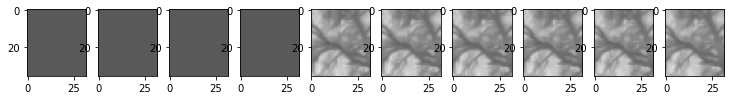

In [10]:
# visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii+45][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)
    # axes[ii,jj].axis('tight')

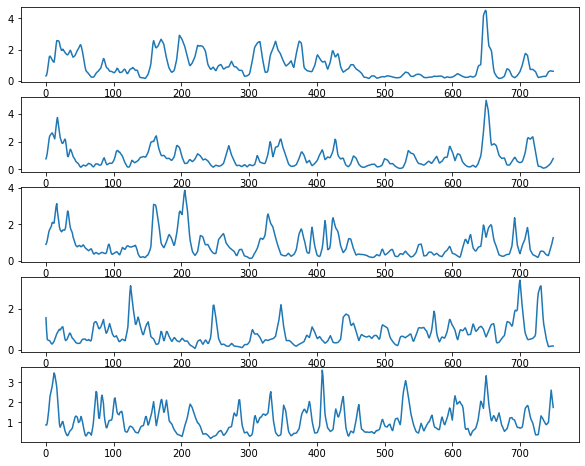

In [11]:
# visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,8))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    # axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [12]:
# define train_loader_length and val_loader_length for function model_train()
train_loader_length = len(train_loader)
val_loader_length = len(val_loader[0])
print(train_loader_length,val_loader_length)

65 3200


#### help functions

In [13]:
loss_mse = nn.MSELoss()

# visualize DNN
# https://github.com/chongyangma/cs231n/blob/master/assignments/assignment3/NetworkVisualization-PyTorch.ipynb
# https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
# https://jacobgil.github.io/deeplearning/filter-visualizations
# https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
# simple version: compute the gradient of the output channel wrt a blank image
# complex version: performa gradient ascend on the target channel, start with noise image
# visualize for final layer 
def vis_model_fl_3d(model,device,xxshape):#visualize for final layer
    model=model.to(device)
    for param in model.parameters():
        param.requires_grad=False
    model=model.eval()
    (tempB,tempC,tempD,tempH,tempW)=xxshape#tempB should be equal to 1
    # xx=torch.randn((tempB,tempC,tempH,tempW),requires_grad=True)
    xx=torch.zeros((tempB,tempC,tempD,tempH,tempW),requires_grad=True)
    if xx.grad is not None:
        xx.grad.data.zero_()
    out=model(xx)
    outlen=out.shape[1]
    yy=torch.zeros(outlen,tempC,tempD,tempH,tempW)
    for ii in range(outlen): # for each neuron
        if xx.grad is not None:
            xx.grad.data.zero_()
        out=model(xx)
        temp=out[0,ii]
        temp.backward() 
        # zero input, 
        # forward through the model, 
        # gradient as the RF-Approximate
        yy[ii]=xx.grad.data # 1 2 50 36 32
        #if xx.grad is not None:
        #    xx.grad.data.zero_()
    return yy

In [14]:
# function for training,(alpha,beta) for L2L1v2 regularizer
def model_train(model,data,optimizer,device,EPOCH,loss_func,valdata,alpha=None,beta=None,alpha2=None,\
                earlystop=False,verbose=True):
    print(datetime.datetime.now())
    #model=model.to(device)
    #model=model.train()
    loss=0.0
    trainlosses=np.zeros((EPOCH))
    vallosses  =np.zeros((EPOCH)) # save validation losses of all epochs until early stopping
    for epoch in range(EPOCH):
        model=model.to(device)
        model=model.train()
        for step, (x,y) in enumerate(data):
            x=torch.from_numpy(x).float()
            y=torch.from_numpy(y).float()
            b_x = x.to(device) 
            b_y = y.to(device)
            if 'dn' in model.__class__.__name__:
                b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
                b_x=torch.clamp(b_x,min=-1.0,max=1.0)
            elif 'vae' in model.__class__.__name__:
                encoded, mu, logvar, decoded = model(b_x)
                loss = loss_func(decoded, b_y, mu, logvar)
            elif 'L2L1' in model.__class__.__name__:
                encoded = model(b_x)
                loss=loss_func(decoded, b_y,alpha,beta,[model.conv1],encoded)
            elif 'ST' in model.__class__.__name__: # spatial and temporal kernel separable
                encoded = model(b_x)
                loss=loss_func(encoded, b_y,alpha,alpha2,beta,[model.conv1_ss],[model.conv1_st],[model.fc1])
            else:
                encoded = model(b_x)
                loss=loss_func(encoded, b_y,alpha,beta,[model.conv1],[model.fc1])
            
            #last epoch to get the training loss, keep the same sample size as validation
            trainlosses[epoch]=trainlosses[epoch]+loss.detach().clone().cpu().data.numpy()
            #
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            #
            if step % 100 == 0 and verbose==True:
                print('Model: ',model.__class__.__name__,'|Epoch: ', epoch,\
                      '| train loss: %.4f' % loss.cpu().data.numpy())
        #one epoch done
        #scheduler.step()
        if epoch>10 and earlystop==True: # epoch>20, early stopping check after each epoch, use CC as a metric
            temploss=model_val(model,valdata,1,device)
            vallosses[epoch]=temploss
            if epoch-np.argmax(vallosses)>4: # >4
                break
        #test
        trainlosses[epoch] =trainlosses[epoch]/len(data)
        temploss=model_val(model,valdata,1,device)
        vallosses[epoch]=temploss
    print ('Epoch: {:} val loss: {:.4f}, finish training!'.format(epoch,vallosses[epoch]))
    print(datetime.datetime.now())
    return trainlosses,vallosses #semilosses #test 
    
    # TO-DO plot 2xloss in one combo of hyperparameters
    #print ('finish training!')
    #print(datetime.datetime.now())
    #train_loss=train_loss/len(data) #train_loader_length
    #print ('Model: ',model.__class__.__name__,'|train loss: %.4f' % train_loss)
    #return train_loss
    #winsound.Beep(400, 3000)#sound alarm when code finishes, freq=400, duration=3000ms
    
#_=model_train(ae3D_4,'normalize',sky',train_loader_shuffle,optimizer,device,EPOCH,loss_mse)    

In [15]:
#use the trained model to test the validation loss
#show one example results
#val_eg: the example used to show results
#val_num: the number of validation dataset, when using gpu, may have memory problem, then set it small
def model_val(model,data,val_eg,device,loss_func=None):
    model=model.to(device)
    model=model.eval()
    #    
    #mse as metric,compute validation loss
    #loss_mse = nn.MSELoss()
    (x,y)=data
    x=torch.from_numpy(x).float()
    #y=torch.from_numpy(y).float()
    b_x = x.to(device) 
    #b_y = y.to(device)
    with torch.no_grad():
        if 'dn' in model.__class__.__name__:
            b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
            b_x=torch.clamp(b_x,min=-1.0,max=1.0)
        if 'vae' in model.__class__.__name__:
            encoded, mu, logvar, decoded = model(b_x)
            # val_loss = loss_func(decoded, b_y, mu, logvar)
        else:
            encoded = model(b_x)
    # CC as metric
    encoded_np=encoded.cpu().data.numpy()
    valcc,valpV=pearsonr(encoded_np.T.flatten(), y.T.flatten())
    if valpV>0.05:
        valcc=0
    #Poisson loss metric
    #y=torch.from_numpy(y).float()
    #b_y = y.to(device)
    #valcc = F.poisson_nll_loss(encoded, b_y,log_input=False, reduction='sum')
    
    #encoded_np=encoded.cpu().data.numpy()
    #valcc,_=pearsonr(encoded_np.flatten(), y.flatten())
    #print ('Model: ',model.__class__.__name__,'|validation cc: %.4f' % valcc)
    #show one example
    #fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(10,2))
    #ax.plot(data[1][:,val_eg],color='r',label='Target')
    #ax.plot(encoded.cpu().data.numpy()[:,val_eg],color='g',label='Predict')
    #ax.legend(loc='best',fontsize=12)
    return valcc
  
#_=model_val(ae3D_4,'normalize','sky',val_loader_shuffle_sky,200,1000,device_cpu,loss_mse)    

In [16]:
# pearson correlation as metric
def model_test(model,data,device,use_pad0_sti=True):
    model=model.to(device)
    model=model.eval()
    (x,y)=data
    x=torch.from_numpy(x).float()
    b_x = x.to(device) 
    encoded = model(b_x)
    encoded_np=encoded.cpu().data.numpy()
    if use_pad0_sti==False: # do not use reponses of 0-padding stimulus, here 7 because we use 8 time lags
        encoded_np=encoded_np[7:,:]
        y=y[7:,:]
    testcc,testpvalue=pearsonr(encoded_np.flatten(), y.flatten())
    # show the best example
    testccs=np.zeros(y.shape[1])
    encoded_np=encoded_np+1e-5 #in case all zeros
    for ii in range(len(testccs)):
        testccs[ii],_=pearsonr(encoded_np[:,ii], y[:,ii])
    testccs[np.isnan(testccs)] = 0 #nan to 0
    test_best=np.argmax(testccs)
    fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(10,2))
    ax.plot(y[:,test_best],'o',color='r',linestyle='-',alpha=0.5,label='Target')
    ax.plot(encoded_np[:,test_best],'o',color='g',linestyle='-',alpha=0.5,label='Predict')
    ax.legend(loc='best',fontsize=12)
    print ('Overall pearson correlation coefficient: ',testcc, ' and p-value: ',testpvalue)
    return testcc,testpvalue
    
# model_test(ae3D_4,'normalize',sky',test_loader_shuffle,2000,device,loss_mse)

In [17]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
# device=torch.device('cpu')
# hyperparameters
EPOCH = 50
BATCH_SIZE = 100
#LR = 0.05#original
LR=0.0001
L2=0.0#L2=0.000001#L2 regularization

In [18]:
# save svd results of all neuronal RFs
nt = 50 # time lag
ny = 36
nx = 32
dims = [nt, ny, nx]
def mySVD(w, dims): # only apply to Gaussian or DOG kernel, the center RF is near the frame center
    if len(dims) == 3:
        dims_tRF = dims[0]
        dims_sRF = dims[1:]
        w_old=np.copy(w)
        w=np.reshape(w,(dims_tRF, np.prod(dims_sRF)))
        # Data matrix X, centered X
        w=w-np.mean(w,axis=0)
        U, S, Vt = randomized_svd(w, 3)
        sRF = Vt[0].reshape(*dims_sRF)
        tRF = U[:, 0]
        #change the sign of sRF and tRF to map with 3d RFs, which is unpredicable in SVD
        '''
        tempcc,_=pearsonr(sRF.flatten(), w[-2])
        if tempcc<0:
            sRF = -1 * sRF
            tRF = -1 * tRF
        '''
        '''
        #keep sRF and w[-2] the same scale
        sRF = np.max(w[-2])/np.max(sRF) *sRF
        tRF = np.max(sRF)/np.max(w[-2]) *tRF
        '''
        '''
        tempscale=np.max(np.abs(w[-2]))/np.max(np.abs(sRF))
        sRF = tempscale *sRF
        neww=np.einsum('i,jk->ijk',tRF,sRF)
        tempscale=np.max(w)/np.max(neww)
        tRF = tempscale *tRF
        '''
        '''
        tempscale=np.max(np.abs(w[-2]))/np.max(np.abs(sRF))
        sRF = tempscale *sRF
        tRF = tempscale *tRF
        '''
        peaks, _ = find_peaks(np.abs(tRF)) #peak index
        peak_close2t0=peaks[-1] # peak index close to time point 0
        w_old_peak_blur=cv2.GaussianBlur(w_old[peak_close2t0],(5,5),0)
        sRF_blur=cv2.GaussianBlur(sRF,(5,5),0)
        #sRF, same polarity and magnitude as w_ol
        tempcc,_=pearsonr(sRF_blur.flatten(), w_old_peak_blur.flatten())
        if tempcc<0:
            sRF = -1 * sRF
        tempscale=np.max(np.abs(w_old_peak_blur))/np.max(np.abs(sRF_blur))
        sRF = tempscale *sRF
        #tRF
        #tRF = tempscale *tRF
        #if -np.min(w_old_peak_blur)>np.max(w_old_peak_blur) and tRF[peak_close2t0]>0: #w_old: off, tRF: on
        #    tRF = -1 *tRF
        #elif -np.min(w_old_peak_blur)<np.max(w_old_peak_blur) and tRF[peak_close2t0]<0: #w_old: on, tRF: off
        #    tRF = -1 *tRF
        if tempcc<0:
            tRF = -1 * tRF
    else:
        sRF = w
        tRF = None
    return [sRF, tRF]

##  <font color='red'>ModelSE3d1_Neu150_ST_Exp, spatial and temporal kernel separable, cascaded2</font> 
16 conv kernels 9x9, use nn.Parameter()

In [21]:
class ModelSE3d1_Neu150_ST_Exp(nn.Module):
    def __init__(self):
        super(ModelSE3d1_Neu150_ST_Exp,self).__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=28*24 #36*32 # 28*24 #size of feature
        self.numofneuron=86 #number of neurons
        #
        # spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        #self.conv1_ss.data.uniform_(-1e-4, 1e-4)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1) #(-std*0.001, std*0.001) # 
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(50,1,1),stride=1)
        #
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
    #
    def forward(self, x):
        #encoded = self.conv1_ss(x)
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

In [ ]:
def Ploss_L2L1_SE_ST(recon_x, x, alpha1, alpha2, beta, alpha_x1, alpha_x2, beta_y): 
    # for spatial and temporal separable model
    tempB, tempN =x.size()
    Ploss = F.poisson_nll_loss(recon_x, x,log_input=False, reduction='sum')
    l2temp=0.0
    for temp in alpha_x1:
        l2temp = l2temp+ temp.norm(2)
    l2temp2=0.0
    for temp in alpha_x2:
        l2temp2 = l2temp2+ temp.weight.norm(2)
    L2loss=alpha1*l2temp+alpha2*l2temp2
    #
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.weight.norm(1)
    L1loss=beta*l1temp
    #return (Ploss+L2loss+L1loss)/(tempB* tempN)
    return Ploss+L2loss+L1loss

### Hyperparameter tuning
#### 
ps. took about 3hrs

In [77]:
# ModelSE3d1_Neu150_ST_Exp(), Poisson loss
EPOCH = 100
LR = 1e-4
alpha1s= [1e2,  1e3,  1e4 ] #[1e0,  1e1, 1e2 ]
alpha2s= [1e1,  1e2,  1e3] #[1e0,  1e1, 1e2]
betas  = [1/16, 1/4, 1, 4] #[1/256,1/64, 1/16, 1/4]
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alpha1s)):
    for jj in range(len(alpha2s)):
        for kk in range(len(betas)):
            modelname=str(ii*len(betas)*len(alpha2s)+jj*len(betas)+kk+1)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = ModelSE3d1_Neu150_ST_Exp()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            #temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE_ST,\
            #                 alpha=alpha1s[ii],beta=betas[kk],alpha2=alpha2s[jj])
            temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE_ST,valdata=val_loader,\
                             alpha=alpha1s[ii],beta=betas[kk],alpha2=alpha2s[jj],earlystop=True,verbose=True)
            modeltrainloss.append(temp)
            break
            torch.save(tempmodel.state_dict(),\
                       './out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_'+modelname+'.pth')
            temp=model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
            modelvalloss.append(temp)
            #release gpu memory
            del tempmodel
            torch.cuda.empty_cache()

temp2=np.reshape(np.array(modelvalloss),(3,3,4))
print (temp2)
print (np.max(temp2))
print (temp2.flatten())

2023-07-27 11:20:13.639057
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  0 | train loss: 17529.4355
Model:  ModelSE3d1_Neu150_ST_Exp |Epoch:  1 | train loss: 17121.9883


KeyboardInterrupt: 

#### visualize spatial kernels in UV(up) and green channels

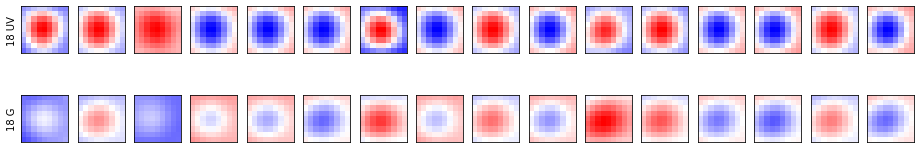

In [22]:
modelnames=np.arange(18,19)
for modelname in modelnames:
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_'+str(modelname)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() 
    # print (conv1_ss.shape) # (16, 2, 1, 9, 9) (out_chan,in_chan,depth,W,H)
    # nrows=int(conv1_ss.shape[0]/8)
    ncols=conv1_ss.shape[0]
    fig, axes = plt.subplots(nrows=2, ncols=ncols,figsize=(ncols,3))
    for ii in range(ncols): 
        tempmax=np.max(np.abs(conv1_ss[ii]))
        axes[0,ii].imshow(conv1_ss[ii,0,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        if ii==0:
            axes[0,ii].set_ylabel('{:} UV'.format(modelname))
            axes[1,ii].set_ylabel('{:} G'.format(modelname))
        axes[0,ii].grid(False) # axes[ii,jj].axis('tight')
        axes[0,ii].set_xticks([])
        axes[0,ii].set_yticks([])
        axes[1,ii].imshow(conv1_ss[ii,1,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,ii].grid(False) # axes[ii,jj].axis('tight')
        axes[1,ii].set_xticks([])
        axes[1,ii].set_yticks([])

#### visualize temporal kernels

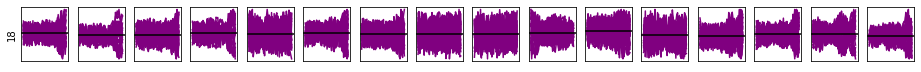

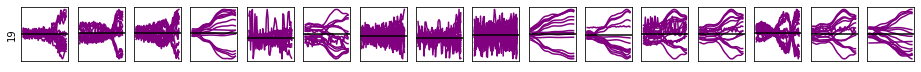

In [23]:
modelnames = np.arange(18,20)
for modelname in modelnames:
    tempmodel = ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_'+str(modelname)+'.pth'))
    tempmodel = tempmodel.to(device_cpu)
    conv1_st = tempmodel.conv1_st.weight.cpu().data.numpy() # shape: (16, 16, 50, 1, 1) NM
    ncols = conv1_st.shape[0]
    fig, axes = plt.subplots(nrows = 1, ncols = ncols,figsize = (ncols,1))
    for ii in range(ncols): 
        # tempmax = np.max(np.abs(conv1_st[ii]))
        for jj in range(conv1_st.shape[1]): # (16, 16, 50, 1, 1)
            axes[ii].plot(conv1_st[ii,jj,:].flatten(),color='purple')
        axes[ii].axhline(y = 0,color='k')
        if ii ==0:
            axes[ii].set_ylabel('{:}'.format(modelname))
        axes[ii].set_xticks([])
        axes[ii].set_yticks([])

### RFs and predictions 

#### visualize 16 spatial kernels of one selected model

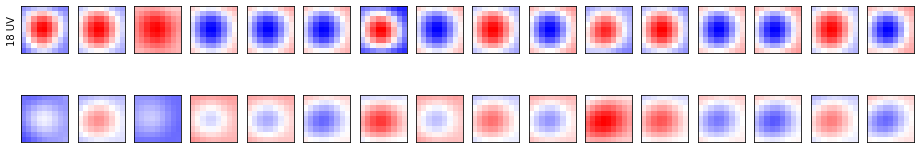

In [24]:
modelnames = np.arange(18,19)
for modelname in modelnames:
    tempmodel = ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_'+str(modelname)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() 
    # print (conv1_ss.shape) # (16, 2, 1, 9, 9)
    # nrows = int(conv1_ss.shape[0]/8)
    ncols = conv1_ss.shape[0]
    fig, axes = plt.subplots(nrows=2, ncols=ncols,figsize=(ncols,3))
    for ii in range(ncols): 
        tempmax = np.max(np.abs(conv1_ss[ii]))
        axes[0,ii].imshow(conv1_ss[ii,0,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        if ii == 0:
            axes[0,ii].set_ylabel('{:} UV'.format(modelname))
        axes[0,ii].grid(False)#axes[ii,jj].axis('tight')
        axes[0,ii].set_xticks([])
        axes[0,ii].set_yticks([])
        axes[1,ii].imshow(conv1_ss[ii,1,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,ii].grid(False) #axes[ii,jj].axis('tight')
        axes[1,ii].set_xticks([])
        axes[1,ii].set_yticks([])
#fig.savefig('out_result/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_conv0.svg')

#### save svd results of example neuronal RFs

In [180]:
# time lag
nt = 50 

ny = 36
nx = 32
dims = [nt, ny, nx]
#
# visualize final layer of model
tempmodel = ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_'+str(18)+'.pth'))
tempmodel=tempmodel.to(device_cpu)

In [262]:
conv1_ss=tempmodel.conv1_ss.cpu().data.numpy()

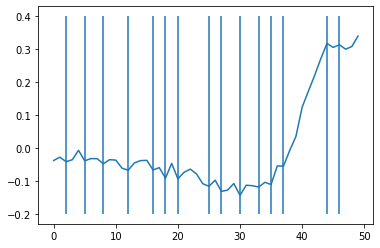

In [240]:
plt.plot(tRF)
for p in peaks:
    plt.vlines(p,-0.2,0.4)

In [235]:
peaks, _ = find_peaks(np.abs(tRF))

In [244]:
w_old=np.copy(w)

Text(0.5, 1.0, 'scaled')

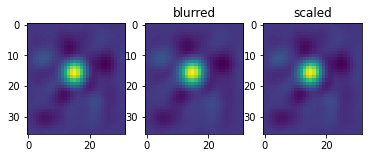

In [261]:
w_old=np.copy(w)
w_old_peak_blur=cv2.GaussianBlur(w_old[peak_close2t0],(5,5),0)
sRF_blur=cv2.GaussianBlur(sRF,(5,5),0)
plt.subplot(131)
plt.imshow(sRF)
plt.subplot(132)
plt.imshow(sRF_blur)
plt.title("blurred")
plt.subplot(133)
plt.imshow(scaled_sRF)
plt.title("scaled")

In [258]:
tempscale=np.max(np.abs(w_old_peak_blur))/np.max(np.abs(sRF_blur))

In [260]:
scaled_sRF = tempscale *sRF

In [241]:
peak_close2t0=peaks[-1]

In [226]:
w = RF_fl_np[1,0]
dim = [50,36,32]
dims_tRF = dims[0]
dims_sRF = dims[1:]

In [227]:
w=np.reshape(w,(dims_tRF, np.prod(dims_sRF)))
# Data matrix X, centered X
w=w-np.mean(w,axis=0)
U, S, Vt = randomized_svd(w, 3)
sRF = Vt[0].reshape(*dims_sRF)
tRF = U[:, 0]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


(86, 2, 50, 36, 32)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

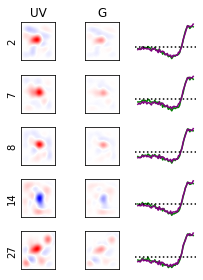

In [27]:
# time lag
nt = 50 

ny = 36
nx = 32
dims = [nt, ny, nx]
#
# visualize final layer of model
tempmodel = ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_'+str(18)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,nt,ny,nx))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape [86, 2, 50, 36, 32]
print (RF_fl_np.shape)
# nums_eg=np.arange(len(RF_fl_np))
#
# plot RFs
nums_eg=[2,7,8,14,27]  #np.arange(len(RF_fl_np)) [63,8,33]
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

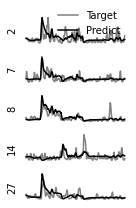

In [28]:
# plot prediction results for example neurons
tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_'+str(18)+'.pth')) #20
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu) 
with torch.no_grad():
    encoded = tempmodel(b_x)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[test_loader[0].shape[2]-1:,:] #use_pad0_sti=False
y=y[test_loader[0].shape[2]-1:,:] #use_pad0_sti=False
#
nums_eg=[2,7,8,14,27]
nrows=len(nums_eg)
# nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.5)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='k',linestyle='-',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    #axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()

## Less training data

### Hyperparameter tuning (40%) (test)

In [ ]:
# # Mode:SE3d1_Neu150_ST_Exp(), Poisson loss
# EPOCH = 100
# LR = 2e-4
# alpha1s = [1e1,  1e2,  1e3 ] #[1e0,  1e1, 1e2 ]
# alpha2s = [1e1,  1e2,  1e3] #[1e0,  1e1, 1e2]
# betas   = [1/16, 1/4, 1, 4] #[1/256,1/64, 1/16, 1/4]
# batch_nums = 28
# modeltrainloss = []
# modelvalloss = []
# for ii in range(len(alpha1s)):
#     for jj in range(len(alpha2s)):
#         for kk in range(len(betas)):
#             modelname = str(ii*len(betas)*len(alpha2s)+jj*len(betas)+kk+1)
#             torch.manual_seed(1)    # reproducible
#             torch.cuda.manual_seed(1)
#             tempmodel = ModelSE3d1_Neu150_ST_Exp()
#             optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
#             # temp = model_train(tempmodel,train_loader,optimizer,device,EPOCH,Ploss_L2L1_SE_ST,\
#             #                 alpha=alpha1s[ii],beta=betas[kk],alpha2=alpha2s[jj])
#             temp = model_train(tempmodel,train_loader[:batch_nums],optimizer,device,EPOCH,Ploss_L2L1_SE_ST,valdata=val_loader,\
#                              alpha=alpha1s[ii],beta=betas[kk],alpha2=alpha2s[jj],earlystop=True,verbose=True)
#             modeltrainloss.append(temp)
#             torch.save(tempmodel.state_dict(),\
#                        './out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_less2_'+modelname+'.pth')
#             temp = model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
#             modelvalloss.append(temp)
#             #release gpu memory
#             del tempmodel
#             torch.cuda.empty_cache()

In [ ]:
# temp2=np.reshape(np.array(modelvalloss),(3,3,4))
# print (temp2)
# print (np.max(temp2))
# print (temp2.flatten())

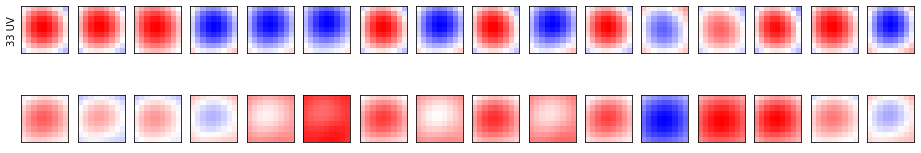

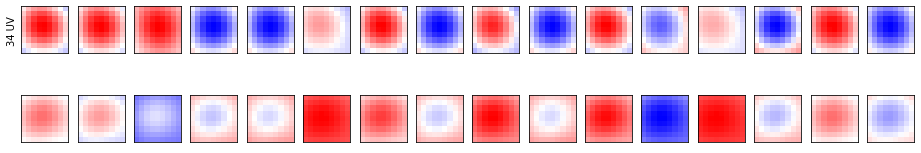

In [30]:
modelnames=np.arange(33,35)
for modelname in modelnames:
    tempmodel= ModelSE3d1_Neu150_ST_Exp()
    tempmodel.load_state_dict(torch.load\
                              ('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_less2_'+str(modelname)+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() 
    # print (conv1_ss.shape) # (32, 2, 1, 9, 9)
    # nrows=int(conv1_ss.shape[0]/8)
    ncols=conv1_ss.shape[0]
    fig, axes = plt.subplots(nrows=2, ncols=ncols,figsize=(ncols,3))
    for ii in range(ncols): 
        tempmax=np.max(np.abs(conv1_ss[ii]))
        axes[0,ii].imshow(conv1_ss[ii,0,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        if ii==0:
            axes[0,ii].set_ylabel('{:} UV'.format(modelname))
        axes[0,ii].grid(False)#axes[ii,jj].axis('tight')
        axes[0,ii].set_xticks([])
        axes[0,ii].set_yticks([])
        axes[1,ii].imshow(conv1_ss[ii,1,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,ii].grid(False) #axes[ii,jj].axis('tight')
        axes[1,ii].set_xticks([])
        axes[1,ii].set_yticks([])

### Different batch number
#### e.g. took about 20 mins

In [32]:
# EPOCH = 100
# LR = 1e-4
# seeds  = [1]
# alpha1s= [1e3] 
# alpha2s= [1e2]
# betas  = [1/4] 
# batch_nums = np.arange(5,66,10) # [int(len(train_loader)/4), int(len(train_loader)/2), int(len(train_loader)*3/4)]
# modeltrainloss=[]
# modelvalloss=[]
# for gg in range(len(batch_nums)):
#     bnum = str(gg+1) # batch number
#     for ii in range(len(seeds)):
#         modelname=str(ii+1)
#         torch.manual_seed(seeds[ii])    # reproducible
#         torch.cuda.manual_seed(seeds[ii])
#         tempmodel = ModelSE3d1_Neu150_ST_Exp()
#         optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
#         # use different amount of training data
#         # by manipulating the amount of batches (5->65) of training data
#         temp = model_train(tempmodel,train_loader[:batch_nums[gg]],optimizer,device,EPOCH,Ploss_L2L1_SE_ST,valdata=val_loader,\
#                     alpha=alpha1s[0],beta=betas[0],alpha2=alpha2s[0],earlystop=True,verbose=False)
#         modeltrainloss.append(temp)
#         torch.save(tempmodel.state_dict(),\
#                 './out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_bnum_'+bnum+'_seed_'+modelname+'.pth')
#         temp = model_val(tempmodel,val_loader,1,device_cpu,loss_mse)
#         modelvalloss.append(temp)
#         # release gpu memory
#         del tempmodel
#         torch.cuda.empty_cache()

2023-07-21 09:06:16.112229
Epoch: 14 val loss: 0.1127, finish training!
2023-07-21 09:06:37.562267
2023-07-21 09:06:40.052837
Epoch: 25 val loss: 0.1976, finish training!
2023-07-21 09:07:58.524952
2023-07-21 09:08:02.468663
Epoch: 23 val loss: 0.2443, finish training!
2023-07-21 09:09:45.194189
2023-07-21 09:09:48.360408
Epoch: 23 val loss: 0.2639, finish training!
2023-07-21 09:12:09.339864
2023-07-21 09:12:12.706676
Epoch: 26 val loss: 0.2814, finish training!
2023-07-21 09:15:28.773570
2023-07-21 09:15:31.756401
Epoch: 30 val loss: 0.2983, finish training!
2023-07-21 09:19:53.934172
2023-07-21 09:19:56.112242
Epoch: 28 val loss: 0.3164, finish training!
2023-07-21 09:24:53.963331


#### RFs and predictions for less training data

In [62]:
batch_nums

array([ 5, 15, 25, 35, 45, 55, 65])

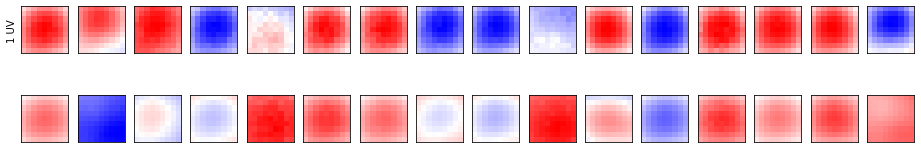

In [61]:
bnum = 2 # batch number 15 train_loader[:15]
modelname = 1 # seed

tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load\
                    ('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_bnum_'+str(bnum)+'_seed_'+str(modelname)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() 
#print (conv1_ss.shape) # (32, 2, 1, 9, 9)
#nrows=int(conv1_ss.shape[0]/8)
ncols=conv1_ss.shape[0]
fig, axes = plt.subplots(nrows=2, ncols=ncols,figsize=(ncols,3))
for ii in range(ncols): 
    tempmax=np.max(np.abs(conv1_ss[ii]))
    axes[0,ii].imshow(conv1_ss[ii,0,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
    if ii==0:
        axes[0,ii].set_ylabel('{:} UV'.format(modelname))
    axes[0,ii].grid(False)#axes[ii,jj].axis('tight')
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    axes[1,ii].imshow(conv1_ss[ii,1,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[1,ii].grid(False) #axes[ii,jj].axis('tight')
    axes[1,ii].set_xticks([])
    axes[1,ii].set_yticks([])

(86, 2, 50, 36, 32)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

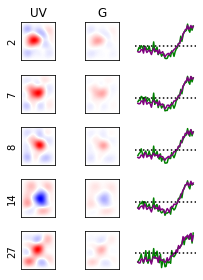

In [64]:
# save svd results of example neuronal RFs
nt = 50 # time lag
ny = 36
nx = 32
dims = [nt, ny, nx]
#
bnum = 3 # batch number 15
modelname = 1 # seed
tempmodel = ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load\
                    ('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_bnum_'+str(bnum)+'_seed_'+str(modelname)+'.pth'))
tempmodel = tempmodel.to(device_cpu)
RF_fl = vis_model_fl_3d(tempmodel,device_cpu,(1,2,nt,ny,nx))
RF_fl_np = RF_fl.cpu().data.numpy() # output shape (86, 2, 50, 36, 32)
print (RF_fl_np.shape)
# nums_eg=np.arange(len(RF_fl_np))
#
# plot RFs
nums_eg = [2,7,8,14,27]  # np.arange(len(RF_fl_np)) [63,8,33]
nrows = len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    # dims = [50, 36, 32]
    # RF_fl_np[2,0].shape -> (50, 36, 32)
    [sRF_UV, tRF_UV] = mySVD(RF_fl_np[nums_eg[ii],0], dims) # uv 
    [sRF_G, tRF_G] = mySVD(RF_fl_np[nums_eg[ii],1], dims) # green
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

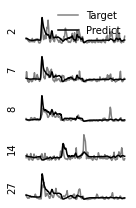

In [68]:
# plot prediction results for example neurons
bnum = 6 # batch number 15
modelname = 1 # seed
tempmodel= ModelSE3d1_Neu150_ST_Exp()
tempmodel.load_state_dict(torch.load\
                    ('./out/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_bnum_'+str(bnum)+'_seed_'+str(modelname)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu) 
with torch.no_grad():
    encoded = tempmodel(b_x)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[test_loader[0].shape[2]-1:,:] #use_pad0_sti=False
y=y[test_loader[0].shape[2]-1:,:] #use_pad0_sti=False
#
nums_eg=[2,7,8,14,27]
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.5)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='k',linestyle='-',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    #axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()